# Bilateral Filter

In [1]:
import numpy as np
import math as math
import cv2 as cv
import matplotlib.pyplot as plt
from time import time

from google.colab.patches import cv2_imshow

from google.colab import drive
drive.mount('/gdrive')

import os

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
os.chdir('/gdrive/My Drive/me574_project_images')

In [3]:
!ls

cat.jpg     filteredcolorful.png  filteredp.png  nba.jpg
eiffel.jpg  filtered.png	  lena.jpg	 rocks.jpg


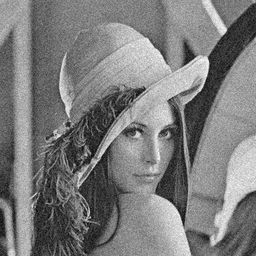

In [4]:
img = cv.imread('lena.jpg', cv.IMREAD_UNCHANGED)
cv2_imshow(img)

## Serial Implementation

Utility functions

In [5]:
def gauss(x,sigma):
    return 1/(math.pi*2*sigma**2)*math.exp(-x**2/(2*sigma**2))

def distance(x1,y1,x2,y2):
    return math.sqrt((x1-x2)**2+(y1-y2)**2)

Filter function

In [6]:
def bilateral_serial(img, rad, sigma_space, sigma_range):
    height = img.shape[0]
    width = img.shape[1]
    imgout = np.zeros([height,width])
    
    for row in range(height):
        for col in range(width):
            weight = 0
            contribution = 0
            for subrow in range(-rad,rad+1):
                stencilrow = row - (rad - subrow)
                if (stencilrow < height) and (stencilrow >= 0):
                    for subcol in range(-rad,rad+1):
                        stencilcol = col - (rad - subcol)
                        if (stencilcol < width) and (stencilcol >= 0):
                            #print(img[qy,qx]-img[row,col])
                            #print('qy =',qy,'qx=',qx)
                            gaussrange = gauss(abs(int(img[row,col])-int(img[stencilrow,stencilcol])),sigma_range)
                            gaussspace = gauss(distance(stencilrow,stencilcol,row,col),sigma_space)
                            w = gaussrange * gaussspace
                            contribution += w * int(img[stencilrow,stencilcol])
                            weight += w
            filteredpix = contribution / weight
            imgout[row,col] = int(filteredpix)
            
    return imgout
                    

Image Processing

original rows/columns/channels (225, 300, 3)
dtype uint8
greyscale rows/columns/channels (225, 300)
filtered rows/columns/channels (225, 300)


serial elapsed time (ms) = 31861.58275604248


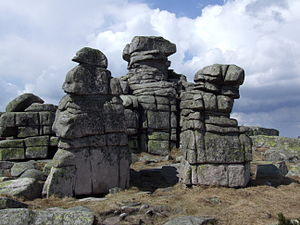

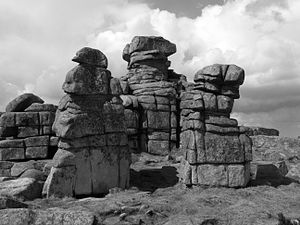

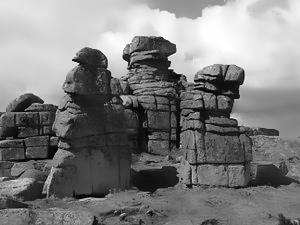

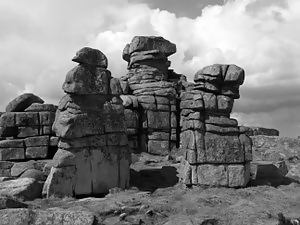

In [7]:
rad = 5
sigma_space = 10
sigma_range = 20

img = cv.imread('rocks.jpg') # lena // nba // rocks // cat
grey = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

# greyscale only
OpenCV = cv.bilateralFilter(grey, rad, sigma_space, sigma_range)
starts = time()
filtereds = bilateral_serial(grey, rad, sigma_space, sigma_range)
filtereds = cv.normalize(src=filtereds, dst=None,alpha=0,beta=255,norm_type=cv.NORM_MINMAX,dtype=cv.CV_8U)
elapseds = (time() - starts) * 1000
cv.imwrite("filtered.png",filtereds)

print('original rows/columns/channels',img.shape)
print('dtype',grey.dtype)
print('greyscale rows/columns/channels',grey.shape)
print('filtered rows/columns/channels',filtereds.shape)
print('\n\nserial elapsed time (ms) =',elapseds)

cv2_imshow(img)
cv2_imshow(grey)
cv2_imshow(filtereds)
cv2_imshow(OpenCV)


serial elapsed time (ms) = 95490.78559875488


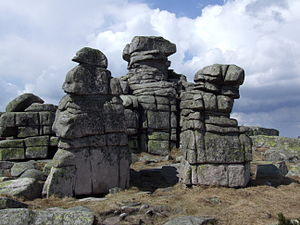

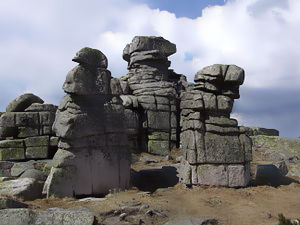

In [8]:
rad = 5
sigma_space = 10
sigma_range = 20

img = cv.imread('rocks.jpg') # lena // nba // rocks // cat // eiffel
b,g,r = cv.split(img)

# colorful
starts = time()
newb = bilateral_serial(b,rad,sigma_space,sigma_range)
newb = cv.normalize(src=newb, dst=None,alpha=0,beta=255,norm_type=cv.NORM_MINMAX,dtype=cv.CV_8U)
newg = bilateral_serial(g,rad,sigma_space,sigma_range)
newg = cv.normalize(src=newg, dst=None,alpha=0,beta=255,norm_type=cv.NORM_MINMAX,dtype=cv.CV_8U)
newr = bilateral_serial(r,rad,sigma_space,sigma_range)
newr = cv.normalize(src=newr, dst=None,alpha=0,beta=255,norm_type=cv.NORM_MINMAX,dtype=cv.CV_8U)
filtereds = cv.merge((newb,newg,newr))
elapseds = (time() - starts) * 1000
print('\nserial elapsed time (ms) =',elapseds)

cv.imwrite("filteredcolorful.png",filtereds)

cv2_imshow(img)
cv2_imshow(filtereds)

## Parallel Implementation

In [9]:
#import os
#os.environ['NUMBA_ENABLE_CUDASIM'] = '1' #NOTE: 1 IS A STRING, NOT AN INT

In [10]:
from numba import cuda,jit,float32

@cuda.jit(device=True)
def gaussian(x,sigma):
    return 1/(math.pi*2*sigma**2)*math.exp(-x**2/(2*sigma**2))

@cuda.jit(device=True)
def pixeldist(x1,y1,x2,y2):
    return math.sqrt(pow((x1-x2),2)+pow((y1-y2),2))

In [11]:
@cuda.jit()
def bf_kernel(d_imgout, d_img, d_rad, d_sigmas, d_sigmar):
    i,j = cuda.grid(2)
    nx, ny = d_img.shape[0], d_img.shape[1]

    if (i < nx) and (j < ny):
        weight = 0
        contribution = 0
        for subrow in range(-d_rad,d_rad+1) :
            stencilrow = i - (rad - subrow)
            if (stencilrow < nx) and (stencilrow >= 0):
                for subcol in range(-rad,rad+1):
                    stencilcol = j - (rad - subcol)
                    if (stencilcol < ny) and (stencilcol >= 0):
                        gaussrange = gaussian(abs(int(d_img[i,j])-int(d_img[stencilrow,stencilcol])),d_sigmar)
                        diff = pixeldist(float32(stencilrow),float32(stencilcol),float32(i),float32(j))
                        gaussspace = gaussian(diff,d_sigmas)
                        w = gaussrange * gaussspace
                        contribution += w * int(d_img[stencilrow,stencilcol])
                        weight += w
        filteredpix = contribution / weight
        d_imgout[i,j] = 0
        d_imgout[i,j] = int(filteredpix)

In [12]:
def bilateral_parallel(img, rad, sigmas, sigmar):
    nx, ny = img.shape[0], img.shape[1]
    d_img = cuda.to_device(img)
    d_imgout = cuda.device_array([nx,ny])
    TPB = 32
    threads = TPB, TPB
    blocks = (nx+TPB-1)//TPB, (ny+TPB-1)//TPB
    
    startp = cuda.event()
    endp = cuda.event()
    startp.record()
    
    bf_kernel[blocks,threads](d_imgout,d_img,rad,sigmas,sigmar)

    endp.record()
    endp.synchronize()
    elapsedp = cuda.event_elapsed_time(startp,endp)
    return d_imgout.copy_to_host(),elapsedp

parallel elapsed time (ms) = 997.8004150390625


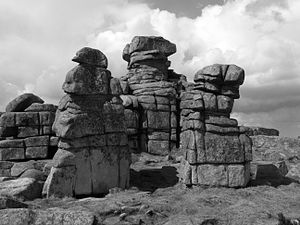

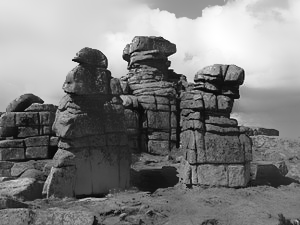

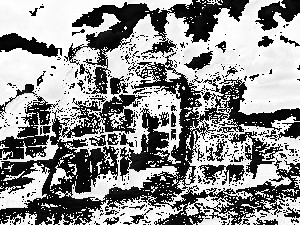

In [13]:
rad = 10
sigma_space = 20
sigma_range = 20

img = cv.imread('rocks.jpg') # lena // nba // rocks // cat
grey = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

filteredp,elapsedp = bilateral_parallel(grey, rad, sigma_space, sigma_range)
filteredp = cv.normalize(src=filteredp, dst=None,alpha=0,beta=255,norm_type=cv.NORM_MINMAX,dtype=cv.CV_8U)
cv.imwrite("filteredp.png",filteredp)
print('parallel elapsed time (ms) =',elapsedp)

cv2_imshow(grey)
cv2_imshow(filteredp)
cv2_imshow(grey - filteredp)

parallel elapsed time (ms) = 68.26412963867188


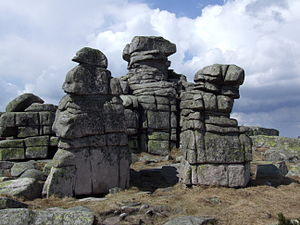

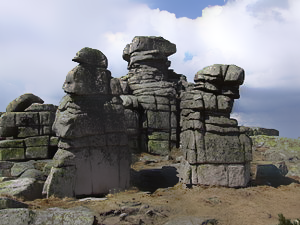

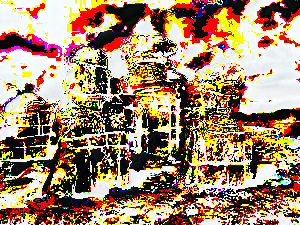

In [14]:
rad = 10
sigma_space = 20
sigma_range = 20

img = cv.imread('rocks.jpg') # lena // nba // rocks // cat // eiffel
b,g,r = cv.split(img)

# colorful
newb,elapsedpb = bilateral_parallel(b,rad,sigma_space,sigma_range)
newb = cv.normalize(src=newb, dst=None,alpha=0,beta=255,norm_type=cv.NORM_MINMAX,dtype=cv.CV_8U)
newg,elapsedpg = bilateral_parallel(g,rad,sigma_space,sigma_range)
newg = cv.normalize(src=newg, dst=None,alpha=0,beta=255,norm_type=cv.NORM_MINMAX,dtype=cv.CV_8U)
newr,elapsedpr = bilateral_parallel(r,rad,sigma_space,sigma_range)
newr = cv.normalize(src=newr, dst=None,alpha=0,beta=255,norm_type=cv.NORM_MINMAX,dtype=cv.CV_8U)
filteredp = cv.merge((newb,newg,newr))
print('parallel elapsed time (ms) =',elapsedpb+elapsedpg+elapsedpr)

cv2_imshow(img)
cv2_imshow(filteredp)
cv2_imshow(img - filteredp)